# AI Jukebox

### Generate Midi File
Plug in trained weights and notes file to generate midi.  

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import sys
from datetime import datetime
import re
import pickle
# from music21 import instrument

import processing as pr
import neural_network as nn
import generate as cr
import utils as ut

/home/cipher000/anaconda3/envs/MusicGenerator1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/cipher000/anaconda3/envs/MusicGenerator1/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
sys.executable

'/home/cipher000/anaconda3/envs/MusicGenerator1/bin/python'

In [3]:
weight_file = 'output/201803282154-Music-200-100-weight-200-3.0149-5.8076.hdf5'
note_file = 'output/201803282154-Music-200-100-input_notes'

timestamp = re.sub(r'[-: ]','',str(datetime.now()).split('.')[0])[:-2]
# output_name = midi_files.split('/')[-3]
# epochs = 200
# batch_size = 128
sequence_length = 100 # the LSTM RNN will consider this many notes
output_tag = 'output/{}-{}-'.format(timestamp, sequence_length)
notes_generated = 500

In [4]:
# convert fully trained weights to midi file
def weights_to_midi(note_file, sequence_length, weight_file):
    with open(note_file, 'rb') as filepath:
        notes = pickle.load(filepath)
    network_input, network_output, n_patterns, n_vocab, pitchnames = pr.prepare_sequences(notes, sequence_length)
    normalized_input = pr.reshape_for_creation(network_input, n_patterns, sequence_length, n_vocab)
    model = nn.create_network(normalized_input, n_vocab, weight_file)
    prediction_output= cr.generate_notes(model, network_input, pitchnames,notes_generated, n_vocab)
    output_notes, midi_file = cr.create_midi(prediction_output, output_tag, sequence_length)
    return output_notes, midi_file, model

In [5]:
# terminal_output = output_tag + 'terminal.log'
# sys.stdout = ut.Logger(terminal_output)
# print("Terminal output being saved at {}".format(terminal_output))
output_notes, midi_file, model = weights_to_midi(note_file, sequence_length, weight_file)
# print("Run Complete. Terminal log saved at {}".format(terminal_output))


**Preparing sequences for training**
Pitchnames (unique notes/chords from 'notes') at length 358: ['0', '0.1', '0.1.5', '0.1.6', '0.2', '0.2.3.7', '0.2.4.7', '0.2.5', '0.2.6', '0.2.7', '0.3', '0.3.5', '0.3.5.8', '0.3.6', '0.3.6.8', '0.3.6.9', '0.3.7', '0.4', '0.4.5', '0.4.6', '0.4.7', '0.5', '0.5.6', '0.6', '1', '1.2', '1.2.4.6.8.10', '1.2.6', '1.2.6.8', '1.3', '1.3.5', '1.3.5.8', '1.3.6', '1.3.7', '1.3.8', '1.4', '1.4.6', '1.4.6.9', '1.4.7', '1.4.7.10', '1.4.7.9', '1.4.8', '1.5', '1.5.8', '1.5.9', '1.6', '1.7', '10', '10.0', '10.0.2.5', '10.0.3', '10.0.4', '10.0.5', '10.1', '10.1.3', '10.1.3.5.6', '10.1.3.6', '10.1.4', '10.1.4.6', '10.1.5', '10.11', '10.11.3', '10.11.3.5', '10.2', '10.2.3', '10.2.4', '10.2.5', '10.3', '11', '11.0', '11.0.4', '11.0.4.6', '11.0.4.7', '11.0.5', '11.1', '11.1.4', '11.1.4.5', '11.1.5', '11.1.6', '11.2', '11.2.4', '11.2.4.6', '11.2.4.7', '11.2.5', '11.2.5.7', '11.2.6', '11.3', '11.3.5', '11.3.6', '11.4', '11.4.5', '2', '2.3', '2.3.7', '2.3.7.10', '2.3.7.9'

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1024)              2105344   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 358)               183654    
_________________________________________________________________
activation_1 (Activation)    (None, 358)               0         
Total params: 2,813,798
Trainable params: 2,813,798
Non-trainable params: 0
_________________________________________________________________


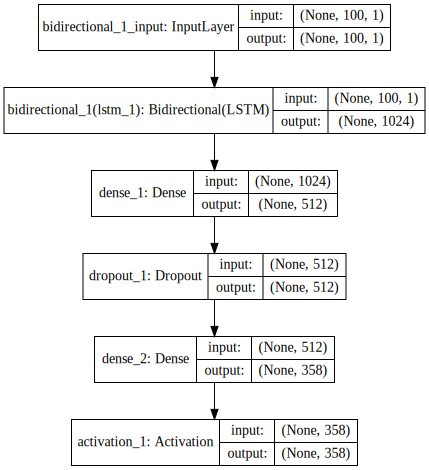

In [7]:
import pydot
import graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

### Convert Midi to Audio

In [9]:
import time
import numpy
import pyaudio
import fluidsynth

pa = pyaudio.PyAudio()
strm = pa.open(
    format = pyaudio.paInt16,
    channels = 2, 
    rate = 44100, 
    output = True)

s = []

fl = fluidsynth.Synth()

# Initial silence is 1 second
s = numpy.append(s, fl.get_samples(44100 * 1))

sfid = fl.sfload("example.sf2")
fl.program_select(0, sfid, 0, 0)

fl.noteon(0, 60, 30)
fl.noteon(0, 67, 30)
fl.noteon(0, 76, 30)

# Chord is held for 2 seconds
s = numpy.append(s, fl.get_samples(44100 * 2))

fl.noteoff(0, 60)
fl.noteoff(0, 67)
fl.noteoff(0, 76)

# Decay of chord is held for 1 second
s = numpy.append(s, fl.get_samples(44100 * 1))

fl.delete()

samps = fluidsynth.raw_audio_string(s)

print(len(samps))
print('Starting playback')
strm.write(samps)

ModuleNotFoundError: No module named 'pyaudio'

In [ ]:
from midi2audio import FluidSynth

In [ ]:
FluidSynth().play_midi(midi_file)

In [ ]:
fs = FluidSynth()
fs.midi_to_audio(midi_file,'output/output.wav')

### Analyze created MIDI

In [ ]:
import pretty_midi
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd

In [ ]:
fs = 16000
rate = 16000
start_pitch = 24
end_pitch = 84

In [ ]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=10):
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))
    
def analyze_midi(midi_file):
    instrument_dict = {}
    pm = pretty_midi.PrettyMIDI(midi_file)
    plt.figure(figsize=(12, 6))
    plot_piano_roll(pm, start_pitch, end_pitch)
    print("Time Signature Changes: {} Instruments: {}".format(len(pm.time_signature_changes), len(pm.instruments)))
    for instrument_num in range(len(pm.instruments)):
        instrument_dict[instrument_num] = {'Notes': len(pm.instruments[instrument_num].notes), 
                                           'Pitch_Bends':len(pm.instruments[instrument_num].pitch_bends),
                                           'Control_Changes':len(pm.instruments[instrument_num].control_changes)}
    instrument_dict = pd.DataFrame(instrument_dict)
    return instrument_dict, pm

In [ ]:
# midi_file = 'output/201803281154-100-lstm_midi.mid'
instrument_dict,pm = analyze_midi(midi_file)
ipd.Audio(pm.synthesize(fs=fs), rate=rate)

### Music21

In [ ]:
from music21 import *

env = environment.Environment()
env['musicxmlPath'] = '/usr/bin/musescore'
env['lilypondPath'] = '/usr/bin/lilypond'
env['musescoreDirectPNGPath'] = '/usr/bin/musescore'
env['pdfPath'] = '/usr/bin/lilypond'
env['graphicsPath'] = '/usr/bin/lilypond'

In [ ]:
# output_notes

In [ ]:
note_stream = stream.Stream()
for note in output_notes:
    note_stream.append(note)
note_stream.show()